# Aperture Photometry Class
daje cazzo che ora funziona

In [1]:
from aperture_class import AperturePhotometry

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import pickle
from astropy.io import fits
%matplotlib widget 

In [2]:
class AperturePhotometry:
    def __init__(self):
        #self.data_path = './data/'
        
        self.readout_noise = 7.4  # [e] photoelectrons
        self.gain = 1.91 # [e/ADU]
        
        self.bias_std = 1.3 # [e] photoelectrons
        self.median_bias = pickle.load(open('output_files/median_bias.p', 'rb'))
        self.median_bias_errors = pickle.load(open('output_files/median_bias_error.p', 'rb'))
        # put the value here if you decided to use a constant value
        self.median_normalized_flat = pickle.load(open('output_files/median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_errors = pickle.load(open('output_files/median_normalized_flat_errors.p', 'rb'))
        
        self.science_path = '../data/'
        self.science_list = np.genfromtxt(self.science_path + 'data.list', dtype=str)
        self.science_size = len(self.science_list)
        
        ylen, xlen  = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    #---------------------------------------------------------------------------------------------------
    # 1)
    def correct_science_frame(self, science_frame):
        science_debiased = science_frame - self.median_bias
        science_corrected = science_debiased / self.median_normalized_flat

        ## Error associated to the science corrected frame
        science_debiased_errors = np.sqrt(self.readout_noise**2 + self.bias_std**2 + science_debiased)
        science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (self.median_normalized_flat_errors/self.median_normalized_flat)**2)
        
        return science_corrected, science_corrected_errors
    
    # 2)
    def compute_centroid(self, science_frame, x_target_initial, y_target_initial, maximum_number_of_iterations=20):

        for i_iter in range(0, maximum_number_of_iterations):

            if i_iter == 0:
                # first iteration
                x_target_previous = x_target_initial
                y_target_previous = y_target_initial
            else:
                # using the previous result as starting point
                x_target_previous = x_target_refined
                y_target_previous = y_target_refined

            # 2D array with the distance of each pixel from the target star 
            target_distance = np.sqrt((self.X-x_target_previous)**2 + (self.Y-y_target_previous)**2)

            # Selection of the pixels within the inner radius
            annulus_sel = (target_distance < self.sky_inner_radius)

            # Weighted sum of coordinates
            weighted_X = np.sum(science_frame[annulus_sel]*self.X[annulus_sel])
            weighted_Y = np.sum(science_frame[annulus_sel]*self.Y[annulus_sel])

            # Sum of the weights
            total_flux = np.sum(science_frame[annulus_sel])


            # Refined determination of coordinates
            x_target_refined = weighted_X/total_flux
            y_target_refined = weighted_Y/total_flux

            percent_variance_x = (x_target_refined-x_target_previous)/(x_target_previous) * 100.
            percent_variance_y = (y_target_refined-y_target_previous)/(y_target_previous) * 100.
            # exit condition: both percent variance are smaller than 0.1%
            if np.abs(percent_variance_x)<0.1 and  np.abs(percent_variance_y)<0.1:
                  break

        return x_target_refined, y_target_refined
    
    # 4)
    def compute_sky_background(self, science_frame, science_frame_err, x_pos, y_pos):
        target_distance = np.sqrt((self.X-x_pos)**2 + (self.Y-y_pos)**2)

        annulus_selection = (target_distance > self.sky_inner_radius) & (target_distance<=self.sky_outer_radius)

        sky_flux_average = np.sum(science_frame[annulus_selection]) / np.sum(annulus_selection)
        sky_flux_err_average = np.sum(science_frame_err[annulus_selection])/np.sum(annulus_selection)
        return sky_flux_average, sky_flux_err_average
    
    # --------------------------------------------------------------------------------------------------------------------------
    # Final Function for aperture photometry
    def aperture_photometry(self, sky_inner_radius, sky_outer_radius, aperture_radius, x_initial, y_initial):
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)

        self.sky_inner_radius = sky_inner_radius 
        self.sky_outer_radius = sky_outer_radius 
        self.aperture_radius = aperture_radius 
        self.x_initial = x_initial
        self.y_initial = y_initial

        self.aperture = np.empty(self.science_size)
        self.aperture_errors = np.empty(self.science_size)
        self.sky_background = np.empty(self.science_size)
        self.sky_background_errors = np.empty(self.science_size)
        
        for ii_science, science_name in enumerate(self.science_list):
            science_fits = fits.open(self.science_path + science_name)
            
            #You must read the info from the header before closing the file
            self.airmass[ii_science] = science_fits[0].header['AIRMASS']
            self.exptime[ii_science] = science_fits[0].header['EXPTIME']
            self.julian_date[ii_science] = science_fits[0].header['JD']
            
            science_data = science_fits[0].data * self.gain # save the data from the first HDU 
            science_fits.close()

            # 1) step
            science_corrected, science_corrected_errors = self.correct_science_frame(science_data)

            #2) step
            x_refined, y_refined = self.compute_centroid(science_corrected,  self.x_initial, self.y_initial)
            
            #3) step
            self.sky_background[ii_science], self.sky_background_errors[ii_science] = self.compute_sky_background(science_frame=science_corrected,
                                                                                                                  science_frame_err=science_corrected_errors,
                                                                                                                  x_pos=x_refined, y_pos=y_refined)

            science_sky_corrected = science_corrected- self.sky_background[ii_science]
            science_sky_corrected_errors = np.sqrt(science_corrected_errors**2. + self.sky_background_errors[ii_science]**2.)
            

            target_distance = np.sqrt((self.X-x_refined)**2 + (self.Y-y_refined)**2)
            aperture_selection = (target_distance < self.aperture_radius)
            self.aperture[ii_science] =  np.sum(science_sky_corrected[aperture_selection])
            self.aperture_errors[ii_science] = np.sum(science_sky_corrected_errors[aperture_selection]) #da controllare




### Aperture Photometry: Target star - WASP-12

In [3]:
import numpy as np
from time import time
t0 = time()
target_star = AperturePhotometry()
target_star.aperture_photometry(sky_inner_radius=13, sky_outer_radius=18, aperture_radius=8, x_initial=357.5, y_initial=37.6)
t1 = time()
print('elapsed_time=', t1-t0)

/tmp/ipykernel_9203/217896991.py:28: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_9203/217896991.py:28: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_9203/217896991.py:32: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (self.median_normalized_flat_errors/self.median_normalized_flat)**2)
/tmp/ipykernel_9203/217896991.py:32: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (self.median_normalized_flat_errors/self.median_normalized_flat)**2)


elapsed_time= 200.5579764842987


### Aperture Photometry: Reference star

In [4]:
from time import time
t0 = time()
reference_star = AperturePhotometry()
reference_star.aperture_photometry(sky_inner_radius=13, sky_outer_radius=18, aperture_radius=8, x_initial=471.5, y_initial=91.0)
t1 = time()
print('elapsed_time=', t1-t0)

/tmp/ipykernel_9203/217896991.py:28: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_9203/217896991.py:28: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_9203/217896991.py:32: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (self.median_normalized_flat_errors/self.median_normalized_flat)**2)
/tmp/ipykernel_9203/217896991.py:32: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (self.median_normalized_flat_errors/self.median_normalized_flat)**2)


elapsed_time= 128.41669011116028


### JD to BJD convertion

In [5]:
from astropy import coordinates as coord, units as u
target = coord.SkyCoord('06:30:32.80', '+29:40:20.26', unit=(u.hourangle, u.deg), frame='icrs')
print(target)
print(type(target))
print(target.shape)

<SkyCoord (ICRS): (ra, dec) in deg
    (97.63666667, 29.67229444)>
<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
()


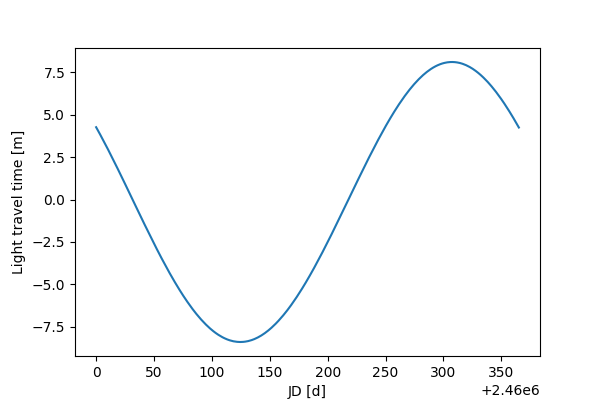

In [6]:
from astropy.time import Time
#https://docs.astropy.org/en/stable/time/

# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10)
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
ltt_plot = tm_plot.light_travel_time(target)

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()

In [7]:
jd = target_star.julian_date + target_star.exptime/86400./2. 

tm = Time(jd, format='jd', scale='utc', location=('45.8472d', '11.569d')) 

# Asiago - Cima Ekar
# 45° 50' 50'' N -> 45.8472
# 11° 34' 08'' E -> 11.569

ltt_bary = tm.light_travel_time(target)  

bjd_tdb = jd + ltt_bary.to_value(u.day)

print('Light travel time in minutes:')
print(ltt_bary.to_value(u.min))

Light travel time in minutes:
[8.19139058 8.19139048 8.19139039 ... 8.19091178 8.19091148 8.19091116]


### Plots

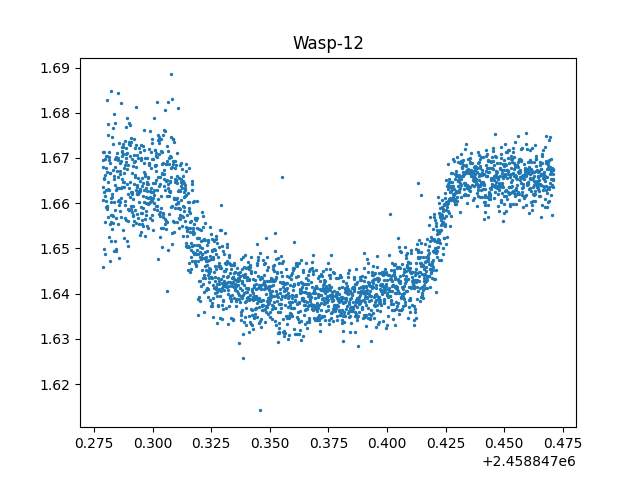

In [8]:
plt.figure()
plt.scatter(bjd_tdb, target_star.aperture/reference_star.aperture, s=2)
plt.title('Wasp-12')
plt.show()